In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import glob
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from PIL import Image

import segmentation_models as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import random
import torch
import requests
import pickle
import re
import os
import cv2

2022-12-08 22:44:29.345113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Segmentation Models: using `keras` framework.


/Users/daniel/opt/anaconda3/envs/daniel-uni-python-38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#these codes are used to loop through the directory
path_images = 'rs19_val/jpgs/rs19_val/'
path_images_resized = 'rs19_val/960_512/images_resized/'
path_masks = 'rs19_val/uint8/rs19_val/'
path_masks_resized = 'rs19_val/960_512/masks_resized_track/'


# read the tram list and turn it into a dict
tram_list = pd.read_csv('tram_filenames.csv')
tram_dict = tram_list.iloc[:,1:].to_dict()

In [3]:
# pixel labels for each class
tram_track=3 
rail_track=12
track_bed= 15
rail_raised= 17
rail_embedded =18
veg = 8

# Prepare the mask label containing 5 labels related to tracks

- tram image from tram_filenames.csv (list prepared by Aras)
- Input images and Masks -> resized (NN) 960x512 , Median filter
- Prepare Binary Masks for all 5 options of labels related to track identification

In [4]:
image_dataset_resized = []
masked_dataset_resized = []

down_width = 960
down_height = 512
down_points = (down_width, down_height)

for i in range(len(tram_list)):
    image_tram = cv2.imread(path_images+tram_dict['filename_jpg'][i],1)
    mask_tram =  cv2.imread(path_masks+tram_dict['filename_mask'][i],0)
    # Median filter 3x3 and resizing 960x512 (NN Interpolation) (such that the dimensions are divisible by 32 becuase of model requiremnet)
    image_tram = cv2.medianBlur(image_tram, 3)
    image_resized= cv2.resize(image_tram, down_points, interpolation= cv2.INTER_NEAREST)

    #cv2.imwrite(path_images_resized+tram_dict['filename_jpg'][i]+'.jpg', image_resized)
    image_dataset_resized.append(image_resized)

    #repeat for masks
    mask_tram=cv2.medianBlur(mask_tram, 3)
    mask_resized= cv2.resize(mask_tram, down_points, interpolation= cv2.INTER_NEAREST)
 
    # Binary masks for track
    for k,val in enumerate(mask_resized):
        for j,val1 in enumerate(val):
            if (val1==tram_track or val1== rail_track or val1==rail_embedded or val1==rail_raised or val1== track_bed):
                val[j] = 1
            else:
                val[j] = 0
    
    masked_dataset_resized.append(mask_resized)
    #cv2.imwrite(path_masks_resized+tram_dict['filename_mask'][i]+'.png', mask_resized)

image_dataset_resized = np.array(image_dataset_resized)
masked_dataset_resized = np.array(masked_dataset_resized)

pickle.dump(image_dataset_resized, open('image_dataset_resized_track', "wb"))
pickle.dump(masked_dataset_resized, open('mask_dataset_resized_track', "wb"))

print(image_resized.shape)
print(mask_resized.shape)
print(image_dataset_resized.shape)
print(masked_dataset_resized.shape)

## Load the image_dataset (y) and the mask_dataset (X) via pickle

In [ ]:
image_dataset_resized= pickle.load(open("image_dataset_resized_track", "rb"))
masked_dataset_resized = pickle.load(open("mask_dataset_resized_track", "rb"))

## expand dim of prepared mask due to model requiremnet 

In [28]:
print(masked_dataset_resized.shape)
masked_dataset_resized = np.expand_dims(masked_dataset_resized, axis=3)
print(masked_dataset_resized.shape)

(1318, 512, 960)
(1318, 512, 960, 1)


# Split train_test

In [30]:

X_train, X_test, y_train, y_test = train_test_split(image_dataset_resized, masked_dataset_resized, test_size = 0.20, random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(160, 512, 960, 3)
(40, 512, 960, 3)
(160, 512, 960, 1)
(40, 512, 960, 1)


In [31]:
# Preprocessing
# https://segmentation-models.readthedocs.io/en/latest/tutorial.html#models-and-backbones
BACKBONE = 'resnet18'
preprocess_input = sm.get_preprocessing(BACKBONE)

X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

# define the model
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), 'mse']
model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze = True, classes=1)
#why classes=1 -> read more example
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [32]:
history = model.fit(X_train,
                    y_train,
                    batch_size=10, #back to 10 next time    
                    epochs=12,
                    verbose=1,
                    validation_data=(X_test,y_test))

#model.save('saved_model/200in_768_1024_track_batch_10_epoch12.hdf5')
pickle.dump(model, open('model_960_512_trackseg', "wb"))

Epoch 1/12
16/16 [==============================] - 937s 60s/step - loss: 0.5598 - accuracy: 0.7521 - iou_score: 0.3205 - mse: 0.1849 - val_loss: 17.6911 - val_accuracy: 0.9098 - val_iou_score: 0.0422 - val_mse: 0.0896
Epoch 2/12
16/16 [==============================] - 850s 52s/step - loss: 0.2789 - accuracy: 0.9297 - iou_score: 0.4665 - mse: 0.0700 - val_loss: 2.4265 - val_accuracy: 0.9040 - val_iou_score: 0.2785 - val_mse: 0.0870
Epoch 3/12
16/16 [==============================] - 816s 51s/step - loss: 0.1882 - accuracy: 0.9445 - iou_score: 0.5326 - mse: 0.0454 - val_loss: 1.0862 - val_accuracy: 0.8479 - val_iou_score: 0.3080 - val_mse: 0.1320
Epoch 4/12
16/16 [==============================] - 1124s 71s/step - loss: 0.1449 - accuracy: 0.9524 - iou_score: 0.5850 - mse: 0.0357 - val_loss: 0.6215 - val_accuracy: 0.8384 - val_iou_score: 0.3153 - val_mse: 0.1333
Epoch 5/12
16/16 [==============================] - 922s 58s/step - loss: 0.1219 - accuracy: 0.9584 - iou_score: 0.6364 - mse:

## Evalaute the metrics

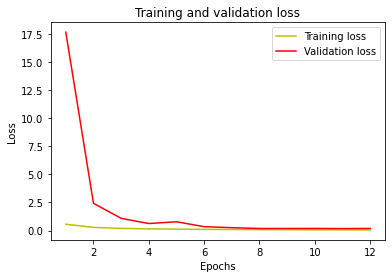

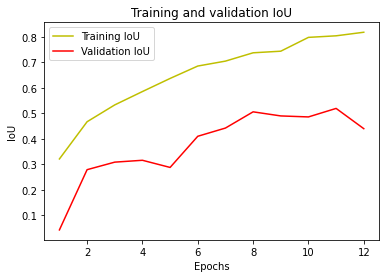

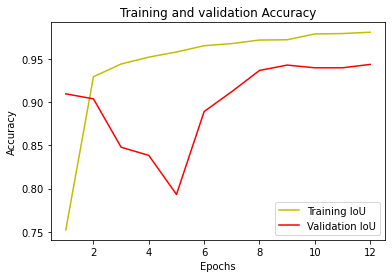

In [33]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

iou = history.history['iou_score']
val_iou = history.history['val_iou_score']

plt.plot(epochs, iou, 'y', label='Training IoU')
plt.plot(epochs, val_iou, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()



acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()